<a target="_blank" href="https://colab.research.google.com/github/PDBeurope/pdbe-notebooks/blob/main/pdbeccdutils_tutorials/spring_school_cadd/pdbeccdutils.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

PDBe CCDUtils is an open-source python package for processing and analyzing small molecules in the PDB. Small-molecule data in the PDB is available as [Chemical Component Dictionary (CCD)](http://www.wwpdb.org/data/ccd) or [Biologically Interesting Molecule reference Dictioanry (BIRD)](http://www.wwpdb.org/data/bird) in PDBX/mmCIF format. PDBe CCDUtils provides streamlined access to all metadata of small molecules in the PDB and offers a set of convenient methods to compute various properties using RDKIt such as 

* [Physicochemical properties](#accessing-properties-of-CCD)
* [Matching common fragments and scaffolds](#finding-fragments-and-scaffolds)
* [Mapping to small-molecule databases using UniChem](#fetching-external-mappings-to-other-databases)
* [2D depictions](#2D-Depictions)
* [Similarity using PARITY method](#similarity-using-parity-method)
* [Export to multiple formats](#export-to-different-formats)
 

PDBe CCDUtils also provides methods for identifying all the Covalently Linked Chemical components (CLC) in a macromolecular structure. To findout more, please refer to the publication [PDBe CCDUtils: an RDKit-based toolkit for handling and analysing small molecules in the Protein Data Bank](https://doi.org/10.1186/s13321-023-00786-w)

## Installation of dependencies

In [ ]:
%pip install rdkit

In [ ]:
%pip install pdbeccdutils

In [ ]:
%pip install wget

## Helper functions

In [1]:
import os
import gzip
import requests
from enum import Enum

In [131]:
PDBECHEM_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2"
ENTRY_URL = "https://ftp.ebi.ac.uk/pub/databases/msd/updated_mmcif/all"

class ligandType(Enum):
    CCD = "ccd"
    PRD = "prd"
    CLC = "clc"


def get_ligand_cif(ligand_id: str, ligand_type: ligandType) -> str:
    """
    Downloads and writes ligand CIF from PDBe FTP to a file
    and returns the path

    Args:
        ligand_id: ID of the ligand
        ligand_type: Type of ligand
    
    Returns:
        The path to cif file of ligand
    """
    match ligand_type.value:
        case "ccd":
            ligand_dir = os.path.join("ccd", ligand_id[0], ligand_id)
        case "prd":
            ligand_dir = os.path.join("prd", ligand_id[-1],ligand_id)
        case "clc":
            ligand_dir = os.path.join("clc", ligand_id[-1],ligand_id)
    try:
        ligand_cif_path = os.path.join(PDBECHEM_URL, ligand_dir, f"{ligand_id}.cif")
        response = requests.get(ligand_cif_path)
        assert response.status_code == 200
        ligand_cif_file = os.path.join(os.getcwd(), f"{ligand_id}.cif")
        with open(ligand_cif_file, "wb") as fh:
            fh.write(response.content)

        return ligand_cif_file
    except  AssertionError:
        print(f"Couldn't find the file. Check if {ligand_id} & {ligand_type} are valid, if so try again")


def get_entry_cif(pdb_id: str) -> str:
    """
    Downloads and writes PDB entry updated mmCIF to a file and 
    returns the path

    Args:
        pdb_id: PDB id of an entry

    Returns:
        path to the downloaded file
    """
    entry_url = os.path.join(ENTRY_URL, f"{pdb_id}_updated.cif.gz")
    response = requests.get(entry_url, stream=True)
    response.raise_for_status()
    with open(f"{pdb_id}_updated.cif", "wb") as fh:
        fh.write(gzip.decompress(response.content))

    return f"{pdb_id}_updated.cif"


## Reading small molecule data

In [132]:
from pdbeccdutils.core import ccd_reader

In [133]:
hem_cif = get_ligand_cif("HEM", ligandType.CCD)
hem =  ccd_reader.read_pdb_cif_file(hem_cif)

In [ ]:
hem

CCDReaderResult contains a component object - the core structural representation of small-molecules in PDBe CCDUtils. Component is a wrapper around rdkit.Chem.rdchem.Mol object providing most of its functionality and access metada data from CCD file. 

In [137]:
hem_component = hem.component

## Accessing properties of CCD

Properties in the CCD file and physicochemical properties generated by RDKit can be accessed using attributes of the Component object

In [ ]:
print(f"""
id: {hem_component.id}
name: {hem_component.name}
formula: {hem_component.formula}
inchi: {hem_component.inchi}
inchikey: {hem_component.inchikey}
release status: {hem_component.pdbx_release_status.name}
modified_date: {hem_component.modified_date}
""")

In [ ]:
hem_component.descriptors

In [ ]:
hem_component.physchem_properties

## Fetching external mappings to other databases

In [ ]:
external_mappings = hem_component.fetch_external_mappings(all_mappings=True)
external_mappings

## Finding fragments

PDBe CCDUtils supports search for fragments present in a small molecule from a library of fragments. The fragment library present in PDBe CCDUtils contains 2158 fragments which were manually currated at PDBe and collaborating resources (ENAMINE, DSI). Should you wish to check all the fragments, please check [fragment_library.tsv](https://github.com/PDBeurope/ccdutils/blob/master/pdbeccdutils/data/fragment_library.tsv) file.

In [134]:
from pdbeccdutils.core.fragment_library import FragmentLibrary
from rdkit.Chem import Draw

In [135]:
fragment_library = FragmentLibrary()

In [138]:
fragment_matches = hem_component.library_search(fragment_library)
print(f"No of fragments found: {len(fragment_matches)}")

No of fragments found: 2


In [139]:
fragment_matches

[SubstructureMapping(name='porphin-like', mol=<rdkit.Chem.rdchem.Mol object at 0x7f8689b48740>, source='PDBe', mappings=((5, 6, 7, 1, 14, 39, 17, 16, 15, 2, 21, 40, 24, 3, 28, 41, 31, 0, 4, 38, 30, 29, 23, 22),)),
 SubstructureMapping(name='pyrrole', mol=<rdkit.Chem.rdchem.Mol object at 0x7f8689b48dd0>, source='PDBe', mappings=((4, 5, 6, 7, 38), (21, 22, 23, 24, 40)))]

In [ ]:
fragment_mols = [fragment.mol for fragment in hem_component.fragments]
img = Draw.MolsToGridImage(fragment_mols, legends = [fragment.name for fragment in hem_component.fragments])
img

## Finding scaffolds

PDBe CCDUtils supports identification of scaffolds of small moelcules in PDB using the RDKit functionality. Currently it supports three types of scaffolding methods
* MurckoScaffold
* MurckoScaffoldGeneric
* BRICS

In [ ]:
from pdbeccdutils.core.models import ScaffoldingMethod

In [ ]:
murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoScaffold)
generic_murcko_scaffolds = hem_component.get_scaffolds(scaffolding_method = ScaffoldingMethod.MurckoGeneric)
brics_scaffolds = hem_component.get_scaffolds(scaffolding_method=ScaffoldingMethod.Brics)

In [ ]:
murcko_scaffolds[0]

## 2D Depictions

PDBe CCDUtils uses [template-based](https://rdkit.org/docs/source/rdkit.Chem.rdDepictor.html#rdkit.Chem.rdDepictor.GenerateDepictionMatching2DStructure) and [connectivity based](https://rdkit.org/docs/source/rdkit.Chem.rdCoordGen.html) methods from RDKit to generate 2D depictions of small moelcules. Templates can either be downloaded from PubChem or provided as a path to a folder containing SDF files. A hand-curated set of [ten templates](https://github.com/PDBeurope/ccdutils/tree/master/pdbeccdutils/data/general_templates) are also provided with PDBe CCDUtils

To find the best depiction of a small molecule, a heuristic-based Depiction Penalty Score (DPS) is defined. A DPS of zero indicates a high-quality 2D depiction, while higher scores indicate lower quality.

In [ ]:
hem_component.mol

In [ ]:
hem_component.export_2d_svg("hem.svg")

In [74]:
from pdbeccdutils.core.depictions import DepictionManager
from pdbeccdutils.utils.pubchem_downloader import PubChemDownloader

In [75]:
pubchem_templates = os.getcwd()
pubchem_downloader = PubChemDownloader(pubchem_templates)

In [ ]:
pubchem_downloader.process_template(hem_component)
depictions = DepictionManager(pubchem_templates)
depiction_result = hem_component.compute_2d(depictions)
depiction_result

In [ ]:
hem_component.mol2D

## Similarity using PARITY method

PDBe CCDUtils supports comparison of small moelcules based on [PARITY](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5890617/) similarity score. PARITY represents the proportion of atoms of same type residing in identical topology between two small molecules

In [ ]:
from pdbeccdutils.computations.parity_method import compare_molecules

In [ ]:
heme_acetyl_cif = get_ligand_cif("HCO", ligandType.CCD)
heme_acetyl_component = ccd_reader.read_pdb_cif_file(heme_acetyl_cif).component

In [ ]:
similarity = compare_molecules(hem_component.mol_no_h, heme_acetyl_component.mol_no_h)

In [ ]:
similarity

## Export to different formats

PDBe CCDUtils presently supports exporting of small molecule data to the following formats
* CIF
* PDB
* SDF
* CML

In [ ]:
from pdbeccdutils.core import ccd_writer

In [ ]:
ccd_writer.write_molecule("hem.sdf",
                          hem_component,
                          )

In [ ]:
ccd_writer.write_molecule("hem.pdb",
                          hem_component,
                          )

# Use cases

## Idenitfying Covalently Linked Components from a PDB entry

In some PDB entries, large ligands are fragmented to smaller CCDs. For example in PDB entry [1e55](https://www.ebi.ac.uk/pdbe/entry/pdb/1e55), the competitive inhibitor **dhurrin** is in compelx with the structure, but it is split into two different CCDs - BGC and DHR. This happens due to the current wwwPDB annotation policies, which recommend splitting of large ligands to smaller CCDs to allow identification of correct stereospecificities and geometry. However, this practise obscures the small molecule data in the PDB archive and make it difficult to automatically identify and map to other databases.

At PDBe, we have created a process to identify these fragmented ligands in the PDB and assign a unique identifier based on the inchikey. You can access them from [PDBeChem FTP](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/clc/). You can also use PDBe CCDUtils to create the complete representaiton of fragmented ligands in a PDB entry.

In [17]:
from pdbeccdutils.helpers import cif_tools
from pdbeccdutils.core.boundmolecule import infer_bound_molecules
from pdbeccdutils.core import clc_reader

In [18]:
def get_clc(pdb_id: str) -> list[clc_reader.CLCReaderResult]:
    """
    Returns a list of CLCReaderResults containing Component 
    object of Covalently Linked Components (CLCs)

    Args:
        pdb_id: PDB ID of an entry

    """
    input_cif = get_entry_cif(pdb_id)
    fixed_mmcif_file = os.path.join(f"{pdb_id}_processed.cif")

    #Keeps only first model, removes alternate conformations of atoms and residues
    cif_tools.fix_updated_mmcif(input_cif, fixed_mmcif_file)

    #
    bms = infer_bound_molecules(
    fixed_mmcif_file, ["HOH"], assembly=False
)
    clc_reader_results = []
    for i, bm in enumerate(bms, start=1):
        bm_id = f"bm{i}"
        reader_result = clc_reader.infer_multiple_chem_comp(
            fixed_mmcif_file, bm, bm_id, sanitize=True
        )
        if reader_result:
            clc_reader_results.append(reader_result)
    
    return clc_reader_results


In [19]:
clc_reader_results = get_clc("1e55")

In [23]:
dhurrin_component = clc_reader_results[0].component

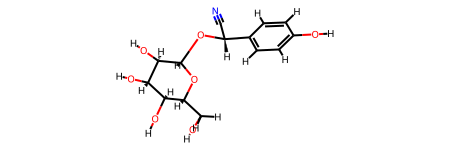

In [24]:
dhurrin_component.mol

In [25]:
dhurrin_component.fetch_external_mappings(all_mappings=True)

[('EPA CompTox Dashboard', 'DTXSID90198142'),
 ('ZINC', 'ZINC000004096638'),
 ('SureChEMBL', 'SCHEMBL50174'),
 ('Nikkaji', 'J10.589I'),
 ('ChEBI', '27826'),
 ('KEGG LIGAND', 'C05143'),
 ('eMolecules', '32231621'),
 ('BRENDA', '30532'),
 ('BRENDA', '1121'),
 ('MetaboLights', 'MTBLC27826'),
 ('Rhea', '27826'),
 ('HMDB', 'HMDB0060471'),
 ('PubChem', '161355'),
 ('PubChem TPHARMA', '24422914'),
 ('NMRShiftDB', '60025950'),
 ('fdasrs', 'P5999IY65C')]

Instead of creating the complete representation of fragmented ligands from PDB entries, you can find the standardized IDs of these ligands from [interacting_chains_with_ligand_functions.tsv](https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/additional_data/pdb_ligand_interactions/interacting_chains_with_ligand_functions.tsv) available from FTP. The below example shows how this can be done for the entry **1e55**. 

In [34]:
import wget
import pandas as pd
from pdbeccdutils.core import clc_reader

In [33]:
wget.download("https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/additional_data/pdb_ligand_interactions/interacting_chains_with_ligand_functions.tsv")

'interacting_chains_with_ligand_functions.tsv'

In [41]:
int_chain_ligand = pd.read_csv("interacting_chains_with_ligand_functions.tsv", sep="\t")

In [57]:
int_chain_ligand.head()

,PDBID,Chain_Symmetry,BestUnpAccession,bmID,inchikey,LigandID,LigandType,annotation
0,100d,A,NaN,bm1,PFNFFQXMRSDOHW-UHFFFAOYSA-N,SPM,CCD,NaN
1,101d,A,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
2,101d,A,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN
3,101d,B,NaN,bm1,JLVVSXFLKOJNIY-UHFFFAOYSA-N,MG,CCD,ion
4,101d,B,NaN,bm2,IDBIFFKSXLYUOT-UHFFFAOYSA-N,NT,CCD,NaN


In [38]:
durrin_cif = get_ligand_cif("CLC_000189", ligandType.CLC)
dhurrin_cif_component = clc_reader.read_clc_cif_file(durrin_cif).component

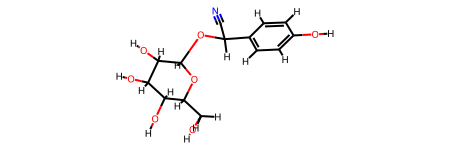

In [40]:
dhurrin_cif_component.mol

## Analysis of Drug-like molecules in PDB

In [116]:
drug_like_molecules = int_chain_ligand.loc[int_chain_ligand["annotation"]=="drug-like", "LigandID"].unique()

In [117]:
drug_like_molecules

array(['BME', 'MES', 'SAH', ..., 'G3D', 'IYJ', '6UB'], dtype=object)

In [56]:
wget.download("https://ftp.ebi.ac.uk/pub/databases/msd/pdbechem_v2/ccd/components.cif")

'components.cif'

In [62]:
ccd_components = ccd_reader.read_pdb_components_file("components.cif")

In [87]:
import matplotlib.pyplot as plt
import numpy as np

In [118]:
#Filter based on number of atoms
drug_like_with_heavy_atoms = []
for ccd in drug_like_molecules:
    num_heavy_atoms = ccd_components[ccd].component.physchem_properties.get("NumHeavyAtoms", 0)
    if num_heavy_atoms > 6:
        drug_like_with_heavy_atoms.append(ccd)


In [120]:
drug_like_weights = []
for ccd in drug_like_with_heavy_atoms:
    if "exactmw" in ccd_components[ccd].component.physchem_properties:
        drug_like_weights.append(ccd_components[ccd].component.physchem_properties["exactmw"])

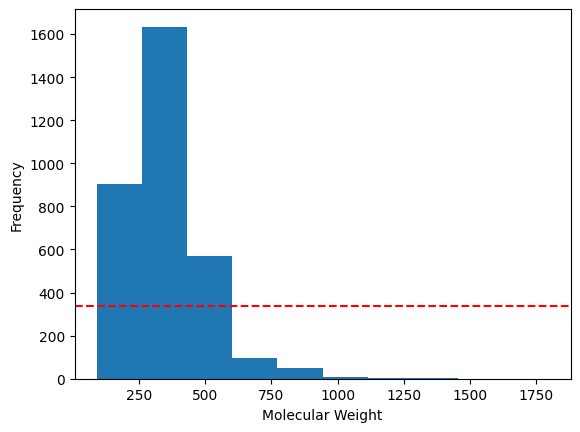

In [130]:
meidan_weight = np.median(drug_like_weights)
plt.hist(drug_like_weights)
plt.axhline(y=meidan_weight, color='r', linestyle='--')
plt.xlabel("Molecular Weight")
plt.ylabel("Frequency")
plt.show()